# Assignment 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import yaml
import os
import pdb
import os


import sys

# Add the path to utils
sys.path.append('..')
from template import utils

In [2]:
utils.set_random_seeds()

### Handling the data

In [3]:
# I am a big fan of config files and I believe it is a good practise
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])


config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 20, 'LR': '5e-4', 'LRConvMix': '1e-3'}


In [17]:
# may differ depending on the problem
transform = transforms.Compose(
    [
     transforms.RandAugment(),
     transforms.ToTensor(), # setup in convmix paper
     transforms.RandomErasing(), # setup in convmix paper
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]) # put more transforms options here

In [5]:
#load datasets (in the future it's possible that the whole process will be in a 
#separate file)
# Missing: Validation set
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [8]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

Image Shapes: torch.Size([64, 3, 32, 32])
Label Shapes: torch.Size([64])


### We can display some images from the dataset
Functions used will probably vastly differ from task to task

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


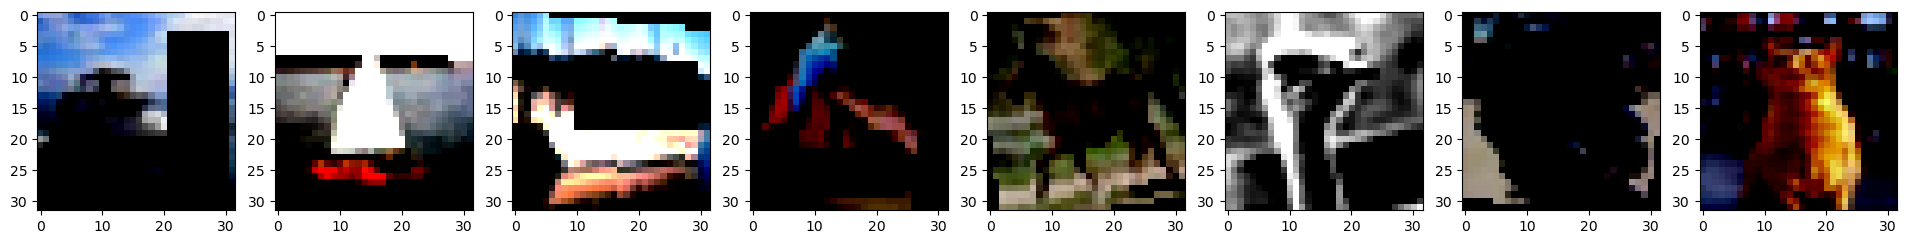

In [9]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,32,32).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

### Creating the model

In [18]:
class CNN(nn.Module):
    """ 
    Adapted to CIFAR-10
    """
    def __init__(self):
        """ Model initializer """
        super().__init__()
        
        # layer 1
        # (3,32,32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        # Layer 2
        # (64, 32, 32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # (64, 16, 16)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        # (128, 16, 16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # (128, 8, 8)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        # (256, 8, 8)
        
        # fully connected classifier
        in_dim = 256 * 8 * 8
        self.fc = nn.Linear(in_features=in_dim, out_features=10)
        
        return
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        out_flat = x.view(cur_b_size, -1)
        y = self.fc(out_flat)
        return y
    
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

### Training the model

In [14]:
from tqdm import tqdm

In [11]:
NUM_EPOCHS = int(config["NUM_EPOCHS"])
LR = float(config["LR"])

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Training loop

In [21]:
# For saving models and checkpoints later
if(not os.path.exists("models")):
    os.makedirs("models")

In [22]:
test_loss_list = []
train_loss_list = []
test_accuracy_list = []
train_accuracy_list = []
# Initialize lists to store gradient information
gradients = []
gradient_norms = []
gradient_max_values = []
gradient_min_values = []
best_loss = 100
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))

    # Calculate test loss, accuracy for currently trained model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images_test, labels_test = data
            # using GPU for inference
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            # calculate model outputs
            outputs_test = model(images_test)
            # calculate test loss
            loss = criterion(outputs_test, labels_test)
            test_loss += loss.item()
            # derive model predictions from out outputs
            predicted = torch.argmax(outputs_test, dim = -1)
            # calculate accuracy
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

        test_loss /= len(testloader)
        accuracy = 100 * correct / total

        print(f"test accuracy: {accuracy}%")

        # Potentially prevent overfitting
        if test_loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
        #saving the best checkpoint
        
    test_loss_list.append(test_loss)
    test_accuracy_list.append(accuracy)
    
    # Turn model back to training mode
    model.train()

    train_loss_list_iter = []
    train_accuracy_list_iter = []
    for i, (imgs, labels) in enumerate(progress_bar):

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        preds = model(imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0] * 100

        train_accuracy_list_iter.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list_iter.append(loss.item())
        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

        '''In the following we calculate gradient information!'''
        
        # Calculate gradient information
        for name, param in model.named_parameters():
            # Tracking the matrices led to oom errors
            if name in ['layers.0.bias']:
                gradients.append(param.grad)
                gradient_norms.append(torch.norm(param.grad).item())
                gradient_max_values.append(param.grad.max().item())
                gradient_min_values.append(param.grad.min().item())

        '''Stop calculating gradient inforamtion'''
    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")
    train_accuracy_list.append(np.mean(train_accuracy_list_iter))
    train_loss_list.append(np.mean(train_loss_list_iter))

  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 59.04%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 67.91%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 71.67%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.74%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.4%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.3%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.66%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.13%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.11%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.47%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.23%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.23%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.26%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.67%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.39%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.22%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.24%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.07%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.56%


Epoch 20 Iter 782: loss 0.01366. : 100%|██████████| 782/782 [00:04<00:00, 194.83it/s]


evaluating the model

In [23]:
n_correct = 0
with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar:
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct


accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:00<00:00, 250.70it/s]

Test accuracy: 73.77%


### Visualization: Loss curves and accuracy development

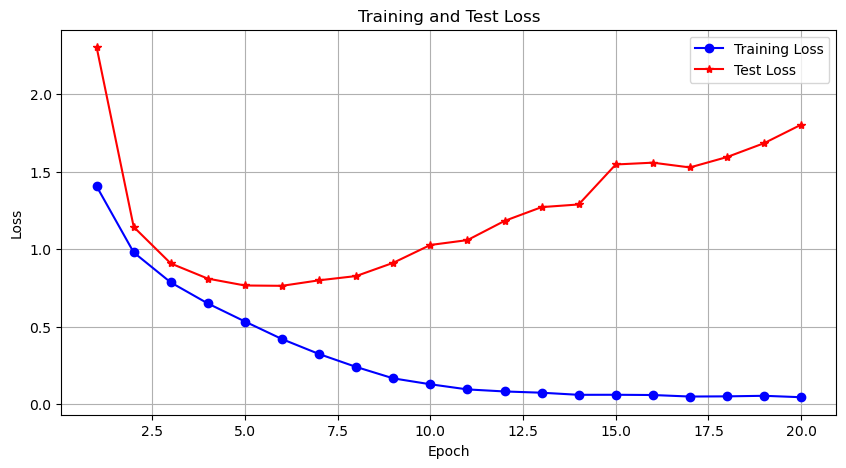

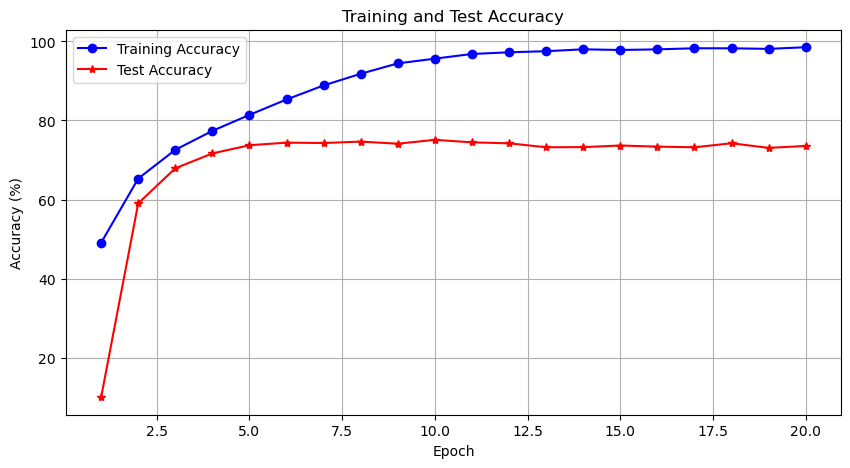

In [24]:
utils.plot_loss_epoch(train_loss_list,  test_loss_list)
utils.plot_accuracy_epoch(test_accuracy_list, train_accuracy=train_accuracy_list)

Training and Test Loss develop as expected. At around epoch 10 the model becomes overconfident in its own predictions, which is why the test loss inceases but the test accuracy stays mostly at the same level

# Evaluation without hyperparameter optimization
Here we achieved an accuracy of 73.77%. We observe a significant increase from the MLP, which achieves an accuracy of around 50%. It is very likely, that the CNN makes better use of the spatial features of an image than the simple MLP. 

# Hyperparameter optimization using optuna

Next we want to "somewhat optimize" our hyperparameters using optuna. For this we create a new model DropoutCNN, in order to continue with the same model until we finish our task.

In [82]:
import optuna
from optuna.trial import TrialState

In [8]:
class DropoutCNN(nn.Module):
    """ 
    Adapted to CIFAR-10
    """
    def __init__(self, kernel_size1 = 3, kernel_size2 = 3, kernel_size3= 3, padding1=1, padding2=1, padding3=1, dropout_prob=0):
        """ Model initializer """
        super().__init__()
        
        # Layer 1
        # (3,32,32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size1, stride=1, padding=padding1)
        self.relu1 = nn.ReLU()
        # Layer 2
        # (64, 32, 32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=dropout_prob)

        # (64, 16, 16)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size2, stride=1, padding=padding2)
        self.relu2 = nn.ReLU()
        # (128, 16, 16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # (128, 8, 8)
        self.dropout2 = nn.Dropout(p=dropout_prob)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_size3, stride=1, padding=padding3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_prob)
        # (256, 8, 8)
        
        # Fully connected classifier
        in_dim = 256 * 8 * 8
        self.fc = nn.Linear(in_features=in_dim, out_features=10)
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        out_flat = x.view(cur_b_size, -1)
        y = self.fc(out_flat)
        return y
    

In [99]:
def define_model(trial):
    # Suggest hyperparameters to optimize
    kernel_size1 = trial.suggest_categorical('kernel_size1', [3, 5])
    kernel_size2 = trial.suggest_categorical('kernel_size2', [3, 5])
    kernel_size3 = trial.suggest_categorical('kernel_size3', [3, 5])

    # Calculate padding based on kernel sizes
    padding1 = 1 if kernel_size1 == 3 else 2
    padding2 = 1 if kernel_size2 == 3 else 2
    padding3 = 1 if kernel_size3 == 3 else 2

    # Create the CNN model with suggested hyperparameters
    model = DropoutCNN(kernel_size1, kernel_size2, kernel_size3, padding1, padding2, padding3)
    return model

In [102]:

# Define the objective function for Optuna
def objective(trial):

    # Define the model
    model = define_model(trial)
    model = model.to(device)
    # lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    # Training Loop
    for epoch in range(NUM_EPOCHS):
        progress_bar = tqdm(trainloader, total=len(trainloader))
        for i, (imgs, labels) in enumerate(progress_bar):

            # using GPU
            imgs, labels = imgs.to(device), labels.to(device)
        
            # forward pass
            preds = model(imgs)

            # calculate accuracy
            with torch.no_grad():
                predicted = preds.argmax(dim=-1)
                correct = (predicted == labels).sum().item()
                accuracy = correct/labels.shape[0]

            train_accuracy_list.append(accuracy)

            # computing error
            loss = criterion(preds, labels)
            train_loss_list.append(loss.item())
            # removing accumulated gradients
            optimizer.zero_grad()
        
            # backprogating error to compute gradients
            loss.backward()
        
            # updating parameters
            optimizer.step()
        
            if(i % 10 == 0 or i == len(trainloader) - 1):
                progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

    # Evaluate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    # prune some trials that are doomed to save time
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy



In [104]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")  # maximize accuracy
study.optimize(objective, n_trials=8)

# Print the best hyperparameters
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-05 23:43:54,473] A new study created in memory with name: no-name-56ec05a8-9563-4924-bef2-6d54a96b6600
Epoch 20 Iter 782: loss 0.18132. : 100%|██████████| 782/782 [00:03<00:00, 226.52it/s]
[I 2023-11-05 23:45:04,377] Trial 0 finished with value: 74.65 and parameters: {'kernel_size1': 3, 'kernel_size2': 3, 'kernel_size3': 5}. Best is trial 0 with value: 74.65.
Epoch 20 Iter 782: loss 0.03113. : 100%|██████████| 782/782 [00:03<00:00, 221.78it/s]
[I 2023-11-05 23:46:14,123] Trial 1 finished with value: 73.86 and parameters: {'kernel_size1': 3, 'kernel_size2': 5, 'kernel_size3': 3}. Best is trial 0 with value: 74.65.
Epoch 20 Iter 782: loss 0.01823. : 100%|██████████| 782/782 [00:03<00:00, 211.64it/s]
[I 2023-11-05 23:47:24,819] Trial 2 finished with value: 75.56 and parameters: {'kernel_size1': 3, 'kernel_size2': 3, 'kernel_size3': 5}. Best is trial 2 with value: 75.56.
Epoch 20 Iter 782: loss 0.01807. : 100%|██████████| 782/782 [00:03<00:00, 234.91it/s]
[I 2023-11-05 23:48:34,

Number of finished trials:  8
Best trial:
  Value:  75.93
  Params: 
    kernel_size1: 3
    kernel_size2: 3
    kernel_size3: 3


In [134]:
kernel_size1 = 3
kernel_size2 = 3
kernel_size3 = 3

# Calculate padding based on kernel sizes
padding1 = 1 if kernel_size1 == 3 else 2
padding2 = 1 if kernel_size2 == 3 else 2
padding3 = 1 if kernel_size3 == 3 else 2

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DropoutCNN(dropout_prob=0) #Default values were the best, so no need to change them.
model.to(device)
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [20]:
test_loss_list = []
train_loss_list = []
test_accuracy_list = []
train_accuracy_list = []
# Initialize lists to store gradient information
gradients = []
gradient_norms = []
gradient_max_values = []
gradient_min_values = []
best_loss = 100
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))

    # Calculate test loss, accuracy for currently trained model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images_test, labels_test = data
            # using GPU for inference
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            # calculate model outputs
            outputs_test = model(images_test)
            # calculate test loss
            loss = criterion(outputs_test, labels_test)
            test_loss += loss.item()
            # derive model predictions from out outputs
            predicted = torch.argmax(outputs_test, dim = -1)
            # calculate accuracy
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

        test_loss /= len(testloader)
        accuracy = 100 * correct / total

        print(f"test accuracy: {accuracy}%")

        # Potentially prevent overfitting
        if test_loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
        #saving the best checkpoint
        
    test_loss_list.append(test_loss)
    test_accuracy_list.append(accuracy)
    
    # Turn model back to training mode
    model.train()

    train_loss_list_iter = []
    train_accuracy_list_iter = []
    for i, (imgs, labels) in enumerate(progress_bar):

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        preds = model(imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0] * 100

        train_accuracy_list_iter.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list_iter.append(loss.item())
        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

        '''In the following we calculate gradient information!'''
        
        # Calculate gradient information
        for name, param in model.named_parameters():
            # Tracking the matrices led to oom errors
            if name in ['layers.0.bias']:
                gradients.append(param.grad)
                gradient_norms.append(torch.norm(param.grad).item())
                gradient_max_values.append(param.grad.max().item())
                gradient_min_values.append(param.grad.min().item())

        '''Stop calculating gradient inforamtion'''
    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")
    train_accuracy_list.append(np.mean(train_accuracy_list_iter))
    train_loss_list.append(np.mean(train_loss_list_iter))

  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 10.08%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 49.98%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 59.04%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 62.17%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 64.82%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 64.82%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 66.72%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 68.44%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 69.91%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 69.71%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 69.92%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 71.23%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 70.28%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 71.55%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 70.73%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 71.59%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 72.38%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 72.51%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 72.72%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.14%


Epoch 20 Iter 782: loss 0.70543. : 100%|██████████| 782/782 [00:20<00:00, 38.02it/s]


In [136]:
n_correct = 0
model.eval()
with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar:
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct


accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

100%|██████████| 157/157 [00:00<00:00, 219.70it/s]

Test accuracy: 75.28%


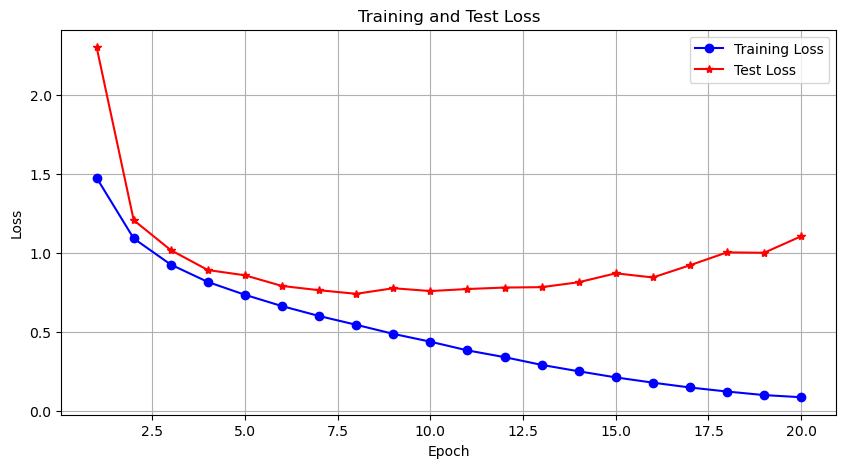

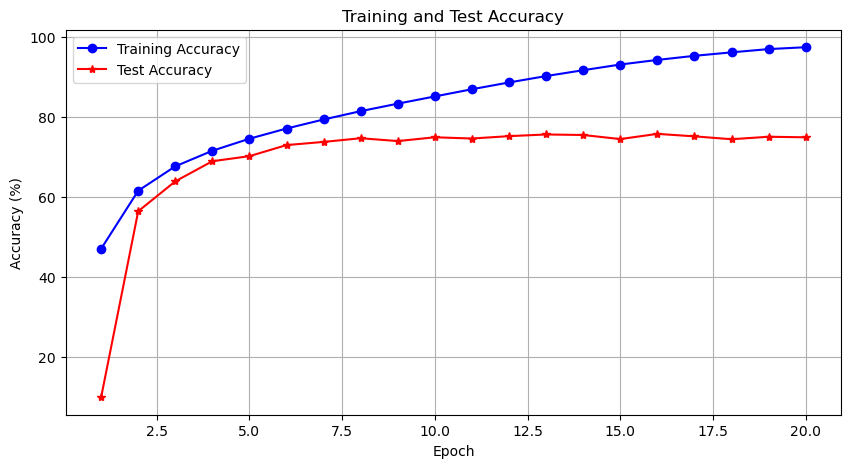

In [137]:
utils.plot_loss_epoch(train_loss_list, test_loss_list)
utils.plot_accuracy_epoch(test_accuracy_list, train_accuracy_list)

# Evaluation after hyperparameter optimization

We observe that our model accuracy increases by arounf 1.5% after small hyperparameteroptimization. Nevertheless, the model still overfits a little and gets overconfident in wrong predictions.

### Kernel visualization

In [107]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DropoutCNN(dropout_prob=0) #Default values were the best, so no need to change them.
# model.to(device)
#model = torch.load("models/checkpoint_epoch_5.pth")

In [21]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 3
conv_layers


In [22]:
transform = transforms.Compose(
    [
     transforms.ToTensor(), # setup in convmix paper
    ])

In [23]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, # 
                                        download=True, transform=transform)

Files already downloaded and verified


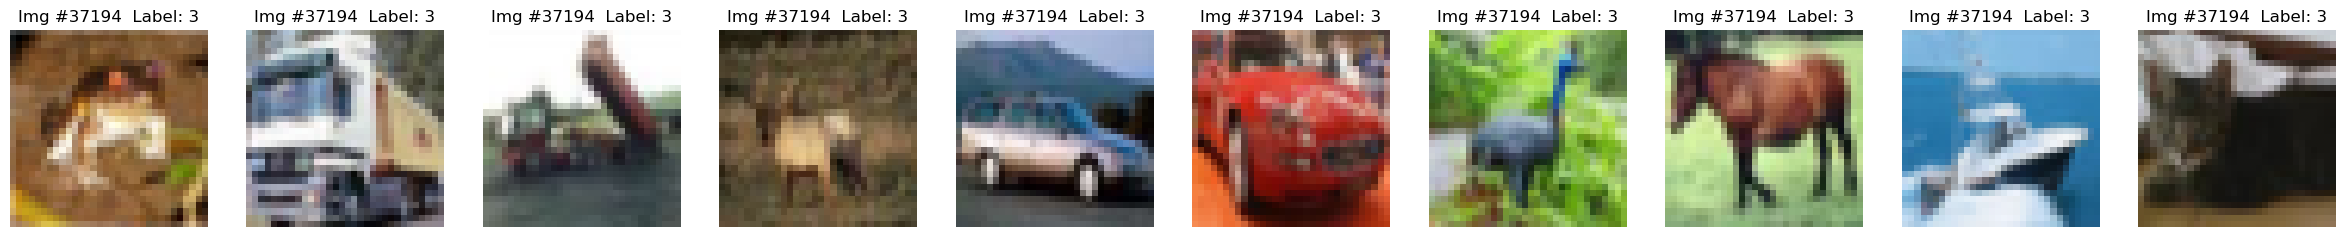

In [24]:
N_IMGS = 10
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)


for i in range(10):
    img = train_dataset[i][0].numpy().reshape(3,32,32).transpose(1, 2, 0)
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    ax[i].axis("off")
plt.show()

In [28]:
import torchvision.transforms.functional as TF

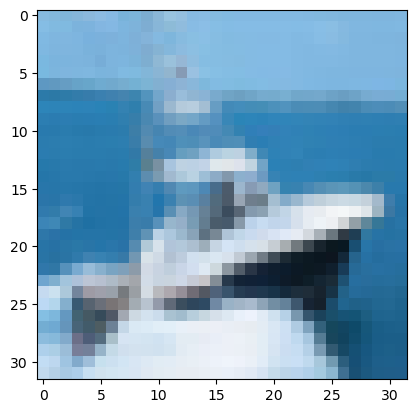

In [29]:
image_index = 8  # You can change this to any index you prefer
image, _ = train_dataset[image_index]
image = image.to(device)

if isinstance(image, torch.Tensor):
    image = TF.to_pil_image(image)

# Display the image
plt.imshow(image)
plt.show()

3
torch.Size([64, 32, 32])
torch.Size([128, 32, 32])
torch.Size([256, 32, 32])
(32, 32)
(32, 32)
(32, 32)


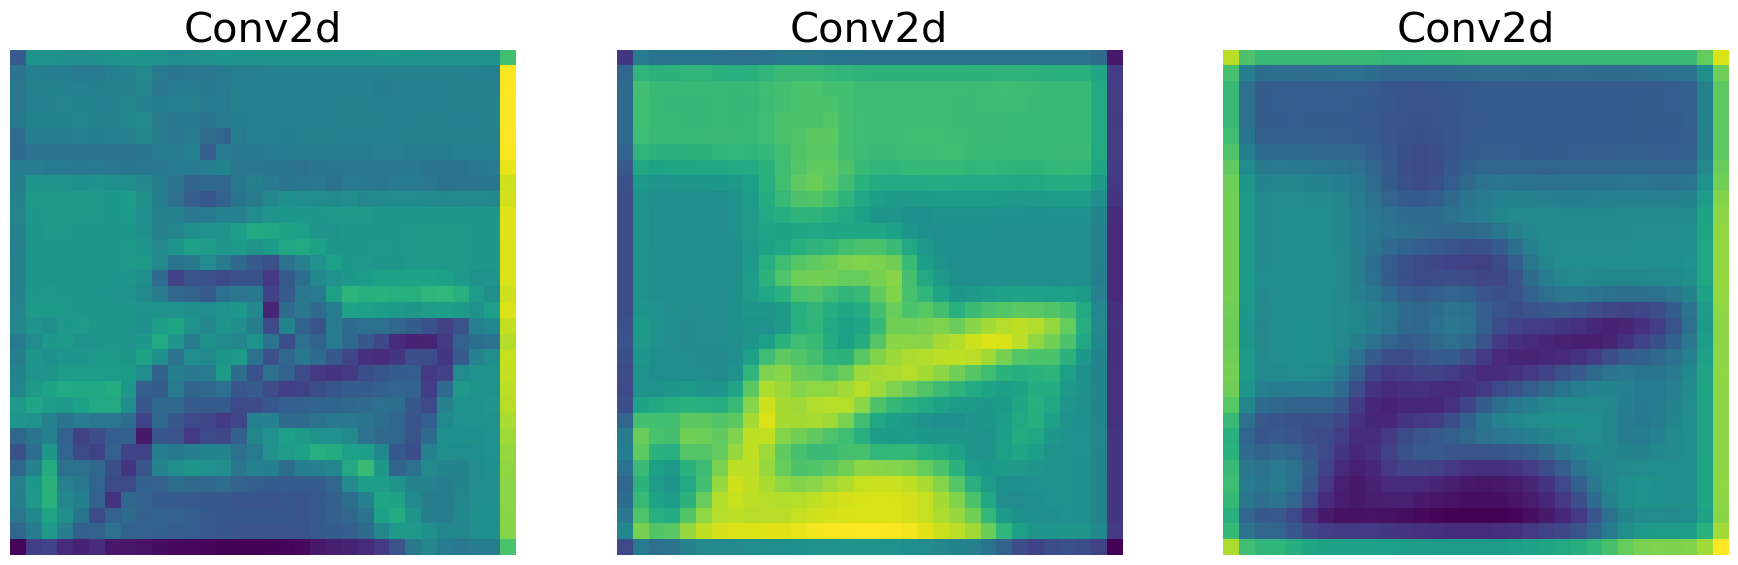

In [27]:


outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

# Dropout

Now we train the model with dropout and check whether we observe any changes. Note, that we added Droputs after Max Pooling layers. Adding Dropouts after convolutional layers appears to be not very popular in the literature. Therefore we opted to add them after the Pooling layers. Disregarding the literature however, one dropout layer after the final convolutional layer achieved positive results, which is why we added one dropout layer after the final convolution. 

In [97]:
model = DropoutCNN(dropout_prob=0.5)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [106]:
test_loss_list = []
train_loss_list = []
test_accuracy_list = []
train_accuracy_list = []
# Initialize lists to store gradient information
gradients = []
gradient_norms = []
gradient_max_values = []
gradient_min_values = []
best_loss = 100
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))

    # Calculate test loss, accuracy for currently trained model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images_test, labels_test = data
            # using GPU for inference
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            # calculate model outputs
            outputs_test = model(images_test)
            # calculate test loss
            loss = criterion(outputs_test, labels_test)
            test_loss += loss.item()
            # derive model predictions from out outputs
            predicted = torch.argmax(outputs_test, dim = -1)
            # calculate accuracy
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

        test_loss /= len(testloader)
        accuracy = 100 * correct / total

        print(f"test accuracy: {accuracy}%")

        # Potentially prevent overfitting
        if test_loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
        #saving the best checkpoint
        
    test_loss_list.append(test_loss)
    test_accuracy_list.append(accuracy)
    
    # Turn model back to training mode
    model.train()

    train_loss_list_iter = []
    train_accuracy_list_iter = []
    for i, (imgs, labels) in enumerate(progress_bar):

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        preds = model(imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0] * 100

        train_accuracy_list_iter.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list_iter.append(loss.item())
        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

        '''In the following we calculate gradient information!'''
        
        # Calculate gradient information
        for name, param in model.named_parameters():
            # Tracking the matrices led to oom errors
            if name in ['layers.0.bias']:
                gradients.append(param.grad)
                gradient_norms.append(torch.norm(param.grad).item())
                gradient_max_values.append(param.grad.max().item())
                gradient_min_values.append(param.grad.min().item())

        '''Stop calculating gradient inforamtion'''
    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")
    train_accuracy_list.append(np.mean(train_accuracy_list_iter))
    train_loss_list.append(np.mean(train_loss_list_iter))

  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 10.05%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 51.14%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 57.87%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 62.06%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 65.43%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 68.05%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 67.64%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 69.93%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 71.58%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 72.27%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.28%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.09%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.11%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.31%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.93%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.3%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 76.11%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 76.15%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.14%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.29%


Epoch 20 Iter 782: loss 0.67041. : 100%|██████████| 782/782 [00:04<00:00, 190.69it/s]


### Test accuracy

In [107]:
n_correct = 0
model.eval()
with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar:
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct


accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:00<00:00, 222.84it/s]

Test accuracy: 77.46%


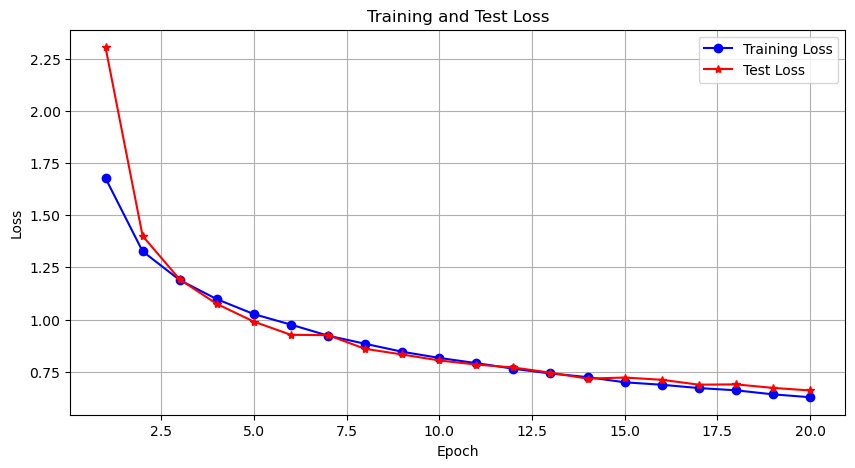

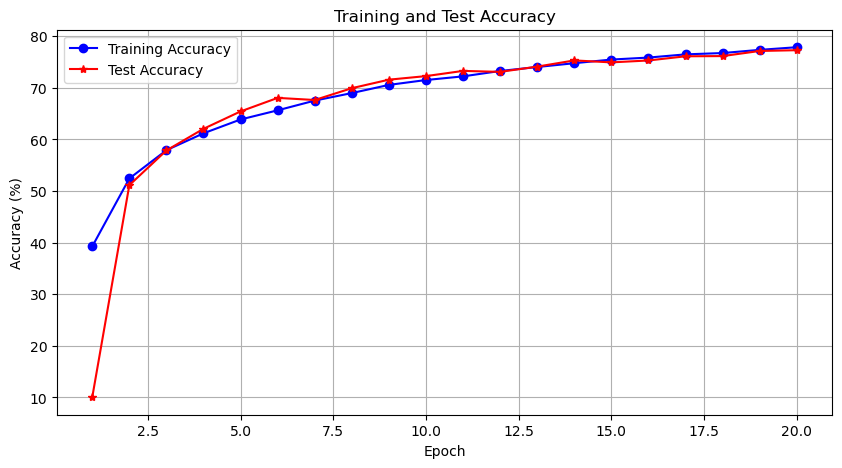

In [108]:
utils.plot_loss_epoch(train_loss_list, test_loss_list)
utils.plot_accuracy_epoch(test_accuracy_list, train_accuracy=train_accuracy_list,)

Looking at out plots, we observe expected results. The test loss is still slightly higher than our training loss. The testing accuracy is slightly below our training accuracy.
Comparing our results to our earlier plots we can see that our model is not overconfident in (wrong) predictions anymore. This is good. Additionally, we observe a 3% increase in accuracy. 

Moreover, we want to note, that our model is even underfitting a little. This indicates that a more complex architecture and/or additional hyperparameter optimization or using more epochs for training might improve our results even further.


## Learning Rate Scheduler

We implemented a simple step learning rate scheduler with a warmup function.

In [9]:
class LearningRateSchedulerWithWarmup():
    '''
    Parameters: 
    optimizer: pytorch optimizer used during training
    lr: learning rate
    warmup_epochs: number of epochs we warm up our learning rate

    milestones: List of epochs when the learning rate will be reduced by a factor
    gamma: Factor by which the learning rate will be reduced
    '''
    def __init__(self, optimizer, lr, milestones, gamma = 0.5, warmup_epochs = 5):
        self.optimizer = optimizer
        self.lr = lr
        self.warmup_epochs = warmup_epochs
        self.milestones = milestones
        self.gamma = gamma
        self.current_lr = 0

    def step(self, epoch):
        if epoch <= self.warmup_epochs:
            # Warm-up phase: Linearly increase learning rate
            self.current_lr = (epoch / self.warmup_epochs) * self.lr
        else:
            if epoch in self.milestones:
                self.current_lr *= self.gamma

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_lr

In [12]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DropoutCNN(dropout_prob=0)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = LearningRateSchedulerWithWarmup(optimizer, LR, milestones=[10, 15, 20], gamma = 0.1, warmup_epochs=5)


In [15]:
test_loss_list = []
train_loss_list = []
test_accuracy_list = []
train_accuracy_list = []
# Initialize lists to store gradient information
gradients = []
gradient_norms = []
gradient_max_values = []
gradient_min_values = []
best_loss = 100
for i, epoch in enumerate(range(NUM_EPOCHS)):
    scheduler.step(i+1)
    progress_bar = tqdm(trainloader, total=len(trainloader))

    # Calculate test loss, accuracy for currently trained model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images_test, labels_test = data
            # using GPU for inference
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            # calculate model outputs
            outputs_test = model(images_test)
            # calculate test loss
            loss = criterion(outputs_test, labels_test)
            test_loss += loss.item()
            # derive model predictions from out outputs
            predicted = torch.argmax(outputs_test, dim = -1)
            # calculate accuracy
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

        test_loss /= len(testloader)
        accuracy = 100 * correct / total

        print(f"test accuracy: {accuracy}%")

        # Potentially prevent overfitting
        if test_loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
        #saving the best checkpoint
        
    test_loss_list.append(test_loss)
    test_accuracy_list.append(accuracy)
    
    # Turn model back to training mode
    model.train()

    train_loss_list_iter = []
    train_accuracy_list_iter = []
    for i, (imgs, labels) in enumerate(progress_bar):

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        preds = model(imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0] * 100

        train_accuracy_list_iter.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list_iter.append(loss.item())
        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

        '''In the following we calculate gradient information!'''
        
        # Calculate gradient information
        for name, param in model.named_parameters():
            # Tracking the matrices led to oom errors
            if name in ['layers.0.bias']:
                gradients.append(param.grad)
                gradient_norms.append(torch.norm(param.grad).item())
                gradient_max_values.append(param.grad.max().item())
                gradient_min_values.append(param.grad.min().item())

        '''Stop calculating gradient inforamtion'''
    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")
    train_accuracy_list.append(np.mean(train_accuracy_list_iter))
    train_loss_list.append(np.mean(train_loss_list_iter))

  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 9.76%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 51.06%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 57.39%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 61.92%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 66.27%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 69.81%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 72.29%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.69%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.04%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.32%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.21%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.33%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.13%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.3%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.35%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.46%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.27%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.42%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.4%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 77.35%


Epoch 20 Iter 782: loss 0.38267. : 100%|██████████| 782/782 [00:03<00:00, 208.47it/s]


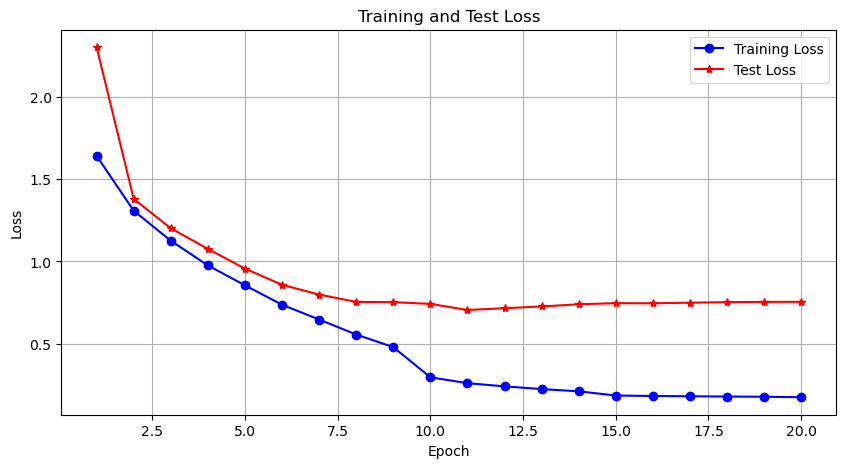

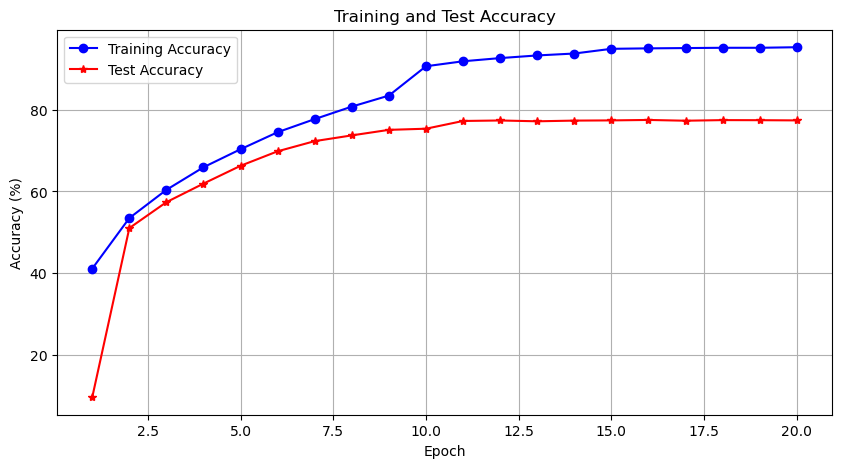

In [16]:
utils.plot_loss_epoch(train_loss_list, test_loss_list)
utils.plot_accuracy_epoch(test_accuracy_list, train_accuracy_list)


# Evaluation Learning Rate Scheduler + Warmup

The learning rate scheduler achieved very good results. Without dropout we detect an increase of around 3% in accuracy, compared to our original optimized CNN model. Looking at the plots we also observe a decrease in overfitting and a decrease in overconfidence.

# Bonus Task: ConvMixer

In [24]:
from tqdm import tqdm

In [35]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x
    
def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
            return nn.Sequential(nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
            nn.GELU(),
            nn.BatchNorm2d(dim),
            *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim))
            for i in range(depth)],      
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(dim, n_classes))

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvMixer(dim=256, depth=4, kernel_size=8,patch_size=1, n_classes=10)
model = model.to(device)
LR = float(config["LRConvMix"])
NUM_EPOCHS = int(config["NUM_EPOCHS"])


In [37]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #adamW was used in the paper
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=NUM_EPOCHS)

In [38]:
@torch.no_grad()
def eval_model(model):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss

In [39]:
loss_hist = []
train_acc_hist = []
valid_loss_hist = []
valid_acc_hist = []
for epoch in range(NUM_EPOCHS):
    loss_list = []
    acc_list = []
    progress_bar = tqdm(enumerate(trainloader), total=len(trainloader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        with torch.no_grad():
            predicted = outputs.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0] * 100
        acc_list.append(accuracy)
        # Getting gradients w.r.t. parameters
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2.0)
        # Updating parameters
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
    
    loss_hist.append(np.mean(loss_list))
    train_acc_hist.append(np.mean(acc_list))
    val_accuracy, valid_loss = eval_model(model)
    print(f"Val accuracy at epoch {epoch}: {round(val_accuracy, 2)}%")
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(val_accuracy)


Epoch 1 Iter 782: loss 1.17502. : 100%|██████████| 782/782 [01:05<00:00, 11.92it/s]


Val accuracy at epoch 0: 52.37%


Epoch 2 Iter 782: loss 0.93681. : 100%|██████████| 782/782 [01:07<00:00, 11.61it/s]


Val accuracy at epoch 1: 62.06%


Epoch 3 Iter 782: loss 1.35745. : 100%|██████████| 782/782 [01:07<00:00, 11.62it/s]


Val accuracy at epoch 2: 67.07%


Epoch 4 Iter 782: loss 0.77455. : 100%|██████████| 782/782 [01:07<00:00, 11.60it/s]


Val accuracy at epoch 3: 70.19%


Epoch 5 Iter 782: loss 0.42936. : 100%|██████████| 782/782 [01:07<00:00, 11.59it/s]


Val accuracy at epoch 4: 72.49%


Epoch 6 Iter 782: loss 0.97805. : 100%|██████████| 782/782 [01:07<00:00, 11.59it/s]


Val accuracy at epoch 5: 73.75%


Epoch 7 Iter 782: loss 0.73825. : 100%|██████████| 782/782 [01:07<00:00, 11.61it/s]


Val accuracy at epoch 6: 74.37%


Epoch 8 Iter 782: loss 0.78687. : 100%|██████████| 782/782 [01:05<00:00, 11.94it/s]


Val accuracy at epoch 7: 75.97%


Epoch 9 Iter 782: loss 0.43928. : 100%|██████████| 782/782 [01:05<00:00, 11.93it/s]


Val accuracy at epoch 8: 77.24%


Epoch 10 Iter 782: loss 1.09266. : 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]


Val accuracy at epoch 9: 78.7%


Epoch 11 Iter 782: loss 0.68178. : 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]


Val accuracy at epoch 10: 79.64%


Epoch 12 Iter 782: loss 0.82273. : 100%|██████████| 782/782 [01:06<00:00, 11.77it/s]


Val accuracy at epoch 11: 80.7%


Epoch 13 Iter 782: loss 0.66141. : 100%|██████████| 782/782 [01:07<00:00, 11.64it/s]


Val accuracy at epoch 12: 81.09%


Epoch 14 Iter 782: loss 0.39639. : 100%|██████████| 782/782 [01:07<00:00, 11.61it/s]


Val accuracy at epoch 13: 82.24%


Epoch 15 Iter 782: loss 0.09699. : 100%|██████████| 782/782 [01:07<00:00, 11.62it/s]


Val accuracy at epoch 14: 83.9%


Epoch 16 Iter 782: loss 0.42467. : 100%|██████████| 782/782 [01:07<00:00, 11.61it/s]


Val accuracy at epoch 15: 84.31%


Epoch 17 Iter 782: loss 0.35565. : 100%|██████████| 782/782 [01:07<00:00, 11.60it/s]


Val accuracy at epoch 16: 84.79%


Epoch 18 Iter 782: loss 0.17321. : 100%|██████████| 782/782 [01:07<00:00, 11.60it/s]


Val accuracy at epoch 17: 85.64%


Epoch 19 Iter 782: loss 0.17440. : 100%|██████████| 782/782 [01:07<00:00, 11.61it/s]


Val accuracy at epoch 18: 85.52%


Epoch 20 Iter 782: loss 0.13939. : 100%|██████████| 782/782 [01:07<00:00, 11.63it/s]


Val accuracy at epoch 19: 85.64%


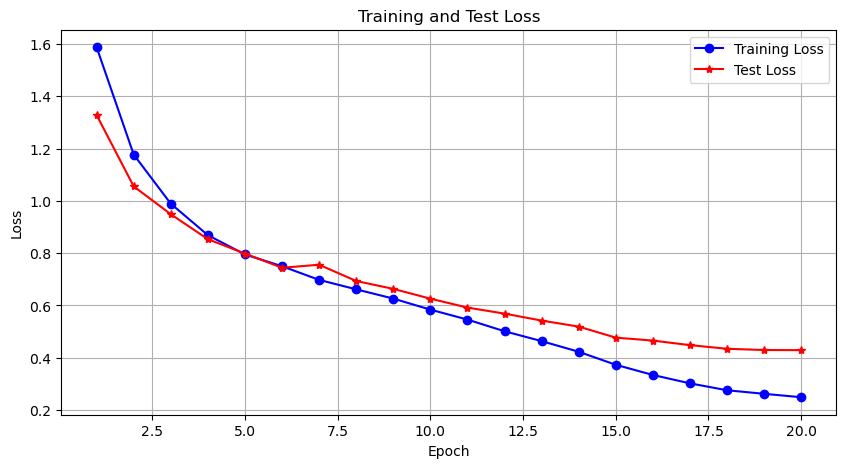

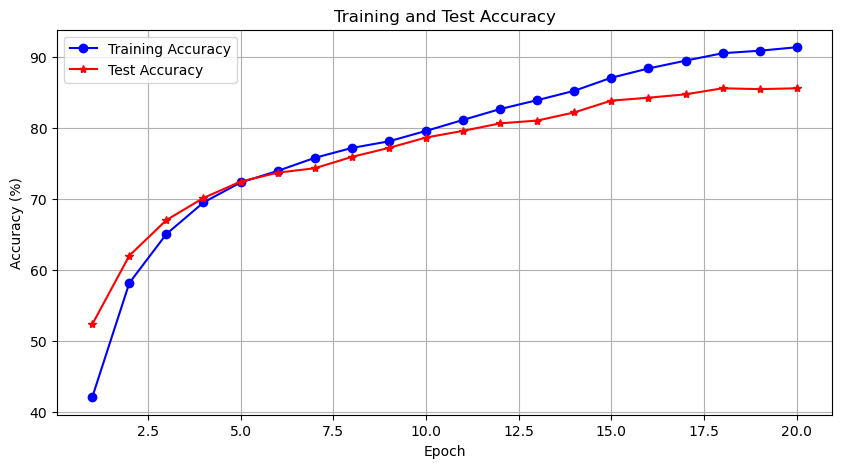

In [40]:
utils.plot_loss_epoch(loss_hist, valid_loss_hist)
utils.plot_accuracy_epoch(valid_acc_hist, train_acc_hist)